<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

!pip install -U spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 2.1 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# библиотеки

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import spacy

from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
# выведем 

display(data.head())
display(data.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

	•	Всего записей: 159 292
	•	Пропусков нет

In [5]:
# Посмотрим количество токсичных комментариев

data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

	•	Нетоксичные комментарии (0): ~89.8%
	•	Токсичные комментарии (1): ~10.2%

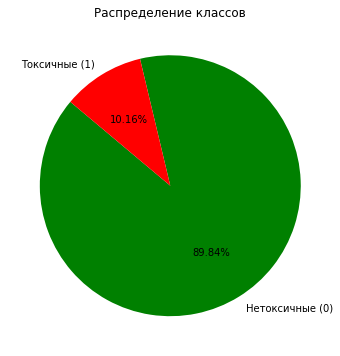

In [6]:
# График распределения классов (токсичных / нетоксичных)

data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))

class_counts = data['toxic'].value_counts()
plt.figure(figsize=(6, 6))
class_counts.plot(kind='pie',
                  autopct='%.2f%%',
                  startangle=140,
                  labels=['Нетоксичные (0)', 'Токсичные (1)'],
                  colors=['green','red'])
plt.title("Распределение классов")
plt.ylabel("")
plt.show()

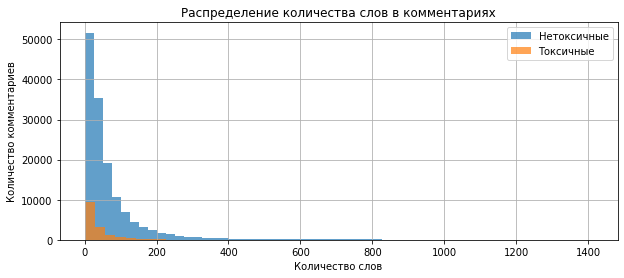

In [7]:
plt.figure(figsize=(10,4))
data[data['toxic']==0]['word_count'].hist(bins=50, alpha=0.7, label='Нетоксичные')
data[data['toxic']==1]['word_count'].hist(bins=50, alpha=0.7, label='Токсичные')
plt.title("Распределение количества слов в комментариях")
plt.xlabel("Количество слов")
plt.ylabel("Количество комментариев")
plt.legend()
plt.show()

In [8]:
# проверка на дубликаты 

data.duplicated().sum()

0

In [9]:
# Предобработка текста

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
# Загружаем модель английского языка без parser и ner

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def spacy_lemmatize(text):
    # 1. Удаляем HTML-теги (если встречаются)
    
    text = re.sub(r'<.*?>', ' ', text)
    
    # 2. Удаляем ссылки (http/https)

    text = re.sub(r'http\S+|www\S+', '', text)
    
    # 3. Приводим к нижнему регистру
    
    text = text.lower()

    # Пропускаем через конвейер spaCy
    
    doc = nlp(text)

    # Собираем леммы, исключая стоп-слова, пунктуацию и ссылки
    
    tokens = [
        token.lemma_ 
        for token in doc 
        if not token.is_stop 
        and not token.is_punct 
        and not token.like_url
    ]

    # Соединяем обратно в строку
    
    return " ".join(tokens)


test_text = "Running quickly! The cats are <b>striped</b> animals. Visit http://example.com"
cleaned = spacy_lemmatize(test_text)
print("Исходный текст:", test_text)
print("Лемматизированный текст (spaCy):", cleaned)



Исходный текст: Running quickly! The cats are <b>striped</b> animals. Visit http://example.com
Лемматизированный текст (spaCy): run quickly cat   striped   animal visit


In [12]:
# Провел лемматизацию и сохранил в отдельный файл 

# data['clean_text'] = data['text'].apply(spacy_lemmatize)

In [14]:
# Сохраняем результат в отдельный CSV

data.to_csv("toxic_comments_lemmatized.csv", index=False)

## Обучение

In [25]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/toxic_comments_lemmatized.csv')
except:
    data = pd.read_csv("toxic_comments_lemmatized.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   word_count  159292 non-null  int64 
 4   clean_text  159190 non-null  object
dtypes: int64(3), object(2)
memory usage: 6.1+ MB


In [26]:
# Обнаружены пропуски 

data[data['clean_text'].isnull()].head(10)

,Unnamed: 0,text,toxic,word_count,clean_text
627,627,Seems we both have some.,0,5,NaN
2400,2400,"Here, here and here.",0,4,NaN
8583,8595,What is it that you can do as well as others? ...,0,12,NaN
8824,8837,What is I 78.146.102.144,0,4,NaN
10068,10081,I might as well give up then.,0,7,NaN
10193,10206,"64.86.141.133""",0,1,NaN
11979,11993,(What I have done) (What have I done?),0,8,NaN
12390,12404,You're just at it again!,0,5,NaN
12665,12680,""", and """"http://www.champawat.gov.in/rti.htm""""...",0,5,NaN
17142,17159,and :here where it has always been,0,7,NaN


In [27]:
# Заменили пропуски на пустные строки

data['clean_text'] = data['clean_text'].fillna('')

In [28]:
# Разделение на выборки 

X = data['clean_text']
y = data['toxic']


In [29]:
# Стратификация важна при дисбалансе (у нас ~10% токсичных)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [30]:
print('\nРазмер обучающей выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)


Размер обучающей выборки: (111504,) (111504,)
Размер тестовой выборки: (47788,) (47788,)


In [31]:
#Функция для обучения с GridSearch

def training(model, param_grid, model_name='Model'):
    """
    model        — «сырой» классификатор (например, LogisticRegression())
    param_grid   — словарь с параметрами для GridSearchCV
    model_name   — название модели (для отладки/печати)
    Возвращает кортеж: (best_estimator, best_score), 
    где best_score — лучшая F1 с кросс-валидации.
    """
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,1), min_df=5)),
        ('model', model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=3,                # 3-фолд кросс-валидация
        n_jobs=-1,           # использовать все ядра
        scoring='f1',        # метрика F1
        verbose=1
    )

    grid.fit(X_train, y_train)
    
    # Лучшая модель по кросс-валидации
    best_estimator = grid.best_estimator_
    best_score = grid.best_score_  # средняя F1 на валидации

    print(f"\n=== {model_name} ===")
    print('Лучшие параметры:', grid.best_params_)
    print(f"F1 (CV лучшее)    : {best_score:.3f}")
    
    return best_estimator, best_score

In [32]:
# Пример параметров (короткая сетка для скорости)
lr_params = {
    'model__C': [0.1, 1, 10], 
    'model__class_weight': [None, 'balanced'],
    'model__random_state': [42],
    'model__max_iter': [1000] 
}

dt_params = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [4, 6],   
    'model__class_weight': [None, 'balanced'],
    'model__random_state': [42]
}

cat_params = {
    'model__iterations': [100],
    'model__depth': [4, 6],
    'model__learning_rate': [0.03],
    'model__auto_class_weights': ['Balanced', None],
    'model__random_state': [42]
}

In [33]:
# Обучаем (GridSearchCV + кросс-валидация)

best_lr, cv_lr = training(LogisticRegression(solver='lbfgs'),
                          lr_params, model_name='LogisticRegression')

best_dt, cv_dt = training(DecisionTreeClassifier(),
                          dt_params, model_name='DecisionTree')

best_cat, cv_cat = training(CatBoostClassifier(logging_level='Silent'),
                            cat_params, model_name='CatBoost')

Fitting 3 folds for each of 6 candidates, totalling 18 fits

=== LogisticRegression ===
Лучшие параметры: {'model__C': 10, 'model__class_weight': None, 'model__max_iter': 1000, 'model__random_state': 42}
F1 (CV лучшее)    : 0.771
Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== DecisionTree ===
Лучшие параметры: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 6, 'model__random_state': 42}
F1 (CV лучшее)    : 0.537
Fitting 3 folds for each of 4 candidates, totalling 12 fits

=== CatBoost ===
Лучшие параметры: {'model__auto_class_weights': 'Balanced', 'model__depth': 6, 'model__iterations': 100, 'model__learning_rate': 0.03, 'model__random_state': 42}
F1 (CV лучшее)    : 0.700


In [34]:
model_scores = [
    ('LogisticRegression', best_lr, cv_lr),
    ('DecisionTree',       best_dt, cv_dt),
    ('CatBoost',           best_cat, cv_cat)
]

# Сортируем по убыванию F1
model_scores.sort(key=lambda x: x[2], reverse=True)

best_model_name, best_model, best_score_cv = model_scores[0]

print(f"\nЛучшая модель по кросс-валидации: {best_model_name}")
print(f"Средняя F1 на кросс-валидации: {best_score_cv:.3f}")


Лучшая модель по кросс-валидации: LogisticRegression
Средняя F1 на кросс-валидации: 0.771


In [35]:
y_pred_test = best_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"\nОценка на тестовой выборке ({best_model_name}): F1 = {f1_test:.3f}")


Оценка на тестовой выборке (LogisticRegression): F1 = 0.777


## Выводы

**Провели кросс-валидацию (GridSearchCV с cv=3) для подбора гиперпараметров у трёх моделей:**
- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier

**По результатам кросс-валидации (train/val):**
- Лучшая средняя `F1` оказалась у `LogisticRegression (≈0.77)`.
- DecisionTreeClassifier (≈0.54) и CatBoostClassifier (≈0.70) дали более низкие результаты.

**Итоговая проверка на тестовой выборке:**
- Итоговая метрика лучшей модели `F1 = 0.777`. Это превосходит требуемый порог `0.75`.